<a href="https://colab.research.google.com/github/EricawithC/projects/blob/main/Bitcoin_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Project

The project was undertaken as part of the Advanced Data Analysis 23/24 course in collaboration with a colleague. The objective was to analyze the Bitcoin dataset by creating a classifier model with KNN and implementing a clustering process.


In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [2]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.9+9-1~22.04 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.9+9-1~22.04 [71.1 MB]
Fetched 119 MB in 4s (31.0 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 121671 

## Setup

The following cell will import the used packages.

In [3]:
from zipfile import ZipFile

import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Dataset

For the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




In [4]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

Mounted at /content/drive
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [5]:
#DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

TXDATA_FILE = "260001-270000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [6]:
# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz
Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz
Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz
Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz
Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz
Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-

### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [14]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)



TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [10]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [8]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes


           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


# **EDA**: data exploratory

This first part consists in computing some statistics on the information available in the dataset.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [11]:
#Computed the top 10 largest transactions based on the sum of the value transfered
top_10_transactions = spark.sql("""
    SELECT *
    FROM transaction
    ORDER BY sum DESC
    LIMIT 10
""")

top_10_transactions.show()

+--------+------+---------+-------------------+
|    txid|height|      sum|               time|
+--------+------+---------+-------------------+
|267952:7|267952|  48000.6|2013-11-04 20:09:31|
|262257:0|262257|40000.312|2013-10-07 16:42:30|
|265063:0|265063|  36000.0|2013-10-21 12:02:31|
|264127:0|264127| 34703.64|2013-10-16 17:20:52|
|265123:1|265123|31904.879|2013-10-21 18:59:31|
|265356:0|265356|24404.504|2013-10-22 17:13:50|
|268028:0|268028|21071.498|2013-11-05 06:37:46|
|262173:0|262173|  21000.0|2013-10-07 04:28:15|
|262171:0|262171|  21000.0|2013-10-07 03:23:53|
|262524:0|262524|  20589.6|2013-10-09 05:56:52|
+--------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [12]:
#Converted Pandas DataFrame to Spark DataFrame
priceDF_spark = spark.createDataFrame(priceDF)
priceDF_spark.createOrReplaceTempView("priceDF")

#Computed a new column with the multiplication of the price and sum of the value transfered in order to obtain the tansaction in terms of USD
merge = spark.sql("SELECT t.*, p.*FROM transaction t JOIN priceDF p ON t.time = p.Date").createOrReplaceTempView("transaction_price")

# Merged transaction and price before
merge = spark.sql("SELECT t.*, p.*, t.Sum * p.Price AS value_usd FROM transaction t JOIN priceDF p ON t.time = p.Date")
merge.createOrReplaceTempView("transaction_price")

# Selected top 10 transactions based on the calculated 'value_usd' column
top_10_transactions = spark.sql("SELECT * FROM transaction_price ORDER BY value_usd DESC LIMIT 10")

top_10_transactions.show()

+----------+------+----------+-------------------+-------------------+-----+------------------+
|      txid|height|       sum|               time|               Date|Price|         value_usd|
+----------+------+----------+-------------------+-------------------+-----+------------------+
|267983:164|267983| 141.18486|2013-11-05 00:00:00|2013-11-05 00:00:00|251.3| 35479.75537567139|
|269658:370|269658| 5.0113926|2013-11-15 00:00:00|2013-11-15 00:00:00|433.9| 2174.443246269226|
|264959:320|264959|   8.95243|2013-10-21 00:00:00|2013-10-21 00:00:00|192.8|  1726.02845993042|
|268631:266|268631|  3.405388|2013-11-09 00:00:00|2013-11-09 00:00:00|367.8|1252.5017493724824|
|260656:569|260656|  8.272893|2013-09-29 00:00:00|2013-09-29 00:00:00|143.9|1190.4692957878112|
|268600:310|268600| 1.5585426|2013-11-09 00:00:00|2013-11-09 00:00:00|367.8| 573.2319716691972|
| 261367:93|261367| 4.2206383|2013-10-03 00:00:00|2013-10-03 00:00:00|131.0| 552.9036140441895|
|266977:225|266977|  1.519648|2013-10-31

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


<ipython-input-15-7d3c3b175703>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactionDF["Time"] = pd.to_datetime(transactionDF["Time"]).dt.date


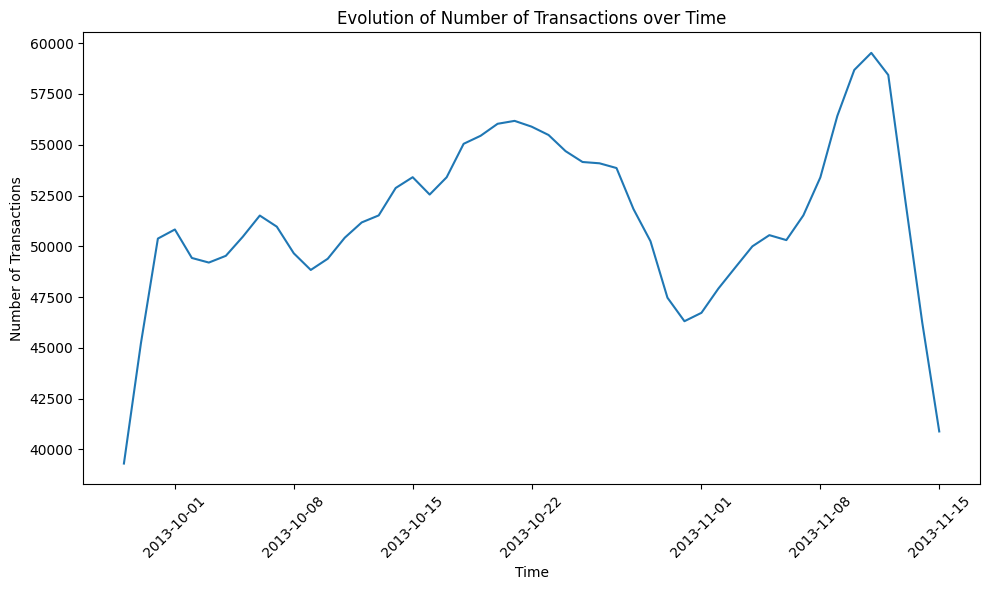

In [15]:
transactionDF["Time"] = pd.to_datetime(transactionDF["Time"]).dt.date

priceDF["Date"] = pd.to_datetime(priceDF["Date"]).dt.date

merged_df = pd.merge(transactionDF, priceDF, left_on="Time", right_on="Date", how="inner")
merged_df.head()

merged_df['value_usd'] = merged_df['Sum'] * merged_df['Price']

# Calculate the number of transactions per day
n_transper_day = transactionDF.groupby("Time")["TxId"].count().reset_index()
n_transper_day["CMA"] = n_transper_day["TxId"].rolling(10, center=True).mean()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_transper_day["Time"], n_transper_day["CMA"])

plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('Evolution of Number of Transactions over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


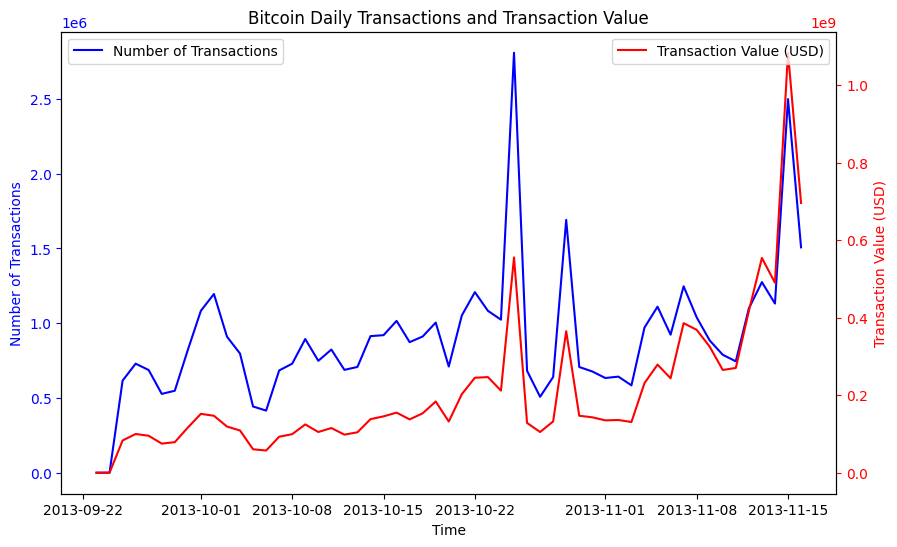

In [17]:
# Calculate the number of transactions per day
btc_daily = merged_df.groupby("Time").agg({"Sum":"sum", "value_usd":"sum"}).reset_index().sort_values("Time")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the number of transactions per day
ax1.plot(btc_daily['Time'], btc_daily['Sum'], color='b', label='Number of Transactions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Transactions', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')

# Creating a second y-axis for transaction value in USD
ax2 = ax1.twinx()
ax2.plot(btc_daily['Time'], btc_daily['value_usd'], color='r', label='Transaction Value (USD)')
ax2.set_ylabel('Transaction Value (USD)', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title('Bitcoin Daily Transactions and Transaction Value')
plt.show()

## Website simulation
Assuming that we want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.


In [18]:
#For the first stats we are going to claculate the account balance

#We start by joint the inputDF and the outputDF
dataDF = pd.merge(outputDF, inputDF, on='TxId', how='inner')
dataDF.drop(columns=['Sum_y','Time_y','Height_y'], inplace=True)
dataDF.columns = ['TxId','Height','Output','Sum','Time','Value','Input']
dataDF
#We created the receive_balance that is for each output is oging to sum all the bitcoins receive
receive_balance = dataDF.groupby("Output")["Sum"].sum().reset_index()
#Is going to change the name of the columns to better undestander
receive_balance.columns = ['Address','Sum_receive']
#We created the out_balance that is for each input is going to sum all the bitcoins send
out_balance = dataDF.groupby("Input")["Sum"].sum().reset_index()
#Is going to change the name of the columns to better undestander
out_balance.columns = ['Address','Sum_send']
#Here we are going to merge these two datasets on the column address
merge_1 = pd.merge(receive_balance,out_balance, on='Address', how='inner')
#Then we created the column account_balance that is how much is address have, that is the Sum that these specidifc address receive minus the sum  tahtthese specidifc address send
merge_1['Account_balance'] = merge_1['Sum_receive']-merge_1['Sum_send']
#Then group by the address and sum the account balance to just show the account_balance for each address
account_balance_per_address = merge_1.groupby("Address")["Account_balance"].sum().reset_index()
#In the end we display the top larger accounts
account_balance_per_address.head()

,Address,Account_balance
0,1111135jHBPwasM92ub4mK6awHKUiTPwq,-0.000141
1,111113xXyHALVNzX9S2NdW1GA5Sz1UxWM,0.167236
2,11117uHSkwU2wwf7uy2ds96S6YEVapCRe,26.227691
3,111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ,38.317380
4,11121RSnVWBPDReJRRpiXV7t7nydVKy5UX,-88.383444


In [19]:
#Here we display the top 5 address with the highest account balance
account_balance_per_address.nlargest(5,"Account_balance")

,Address,Account_balance
381178,15U5NjgAbKqKyGKwayS648WwJoiCCvGnTG,4.333780e+06
895322,1ACKcumkx4M3aQisMMLq32EubPkUNiUfTC,3.479841e+06
781079,199TDefoSBcYK9cGPeRpYkgyDAaxDyHbhH,2.363344e+06
470921,16JSWqX5iAfPySnuLGVEiPLr13mqAx87qN,1.657219e+06
1932645,1KhHvmZXxqGRA821Rsqcs6FF2EwLsddrSX,1.614425e+06


In [20]:
#Second index that we are going to calculate is the Top-3 Commercial Partners for 5 specific adressess

#We start by joint the inputDF and the outputDF
dataDF = pd.merge(outputDF, inputDF, on='TxId', how='inner')
dataDF.drop(columns=['Sum_y','Time_y','Height_y'], inplace=True)
dataDF.columns = ['TxId','Height','Output','Sum','Time','Value','Input']
dataDF

#So first we are going to decide with of the input addresses we are using. In these case make for sense to use the inputs that repeat more.
print("Top 5 input addresses with more transactions")
input_address = dataDF["Input"].value_counts().nlargest(5).reset_index()
print(input_address)
print()
#Then we are going to use the address from the column input to find the top 3 comercial partners from the top 5 address with more transactions

#For the first case we have the following
print("Top 3 comercial partner for the height of the address of 14cZMQk89mRYQkDEj8Rn25AnGoBi5H6uer is")
#We are going to select only the input(address) that we want to
address_1 = dataDF[dataDF["Input"]=="14cZMQk89mRYQkDEj8Rn25AnGoBi5H6uer"]
#Then we are going to count how many times a specific output is repeting with these input and display the 3 largers, that is the top 3 comercial partners
top_commercial_1 = address_1["Output"].value_counts().nlargest(3).reset_index()
#Just change the names of the columns to a better understand
top_commercial_1.columns = ["Address", "Transaction_Count"]
print(top_commercial_1)
print()

#For the second case we have the following
print("Top 3 comercial partner for the input adress of 1dice97ECuByXAvqXpaYzSaQuPVvrtmz6 is")
#We are going to select only the input(address) that we want to
address_2 = dataDF[dataDF["Input"]=="1dice97ECuByXAvqXpaYzSaQuPVvrtmz6"]
#Then we are going to count how many times a specific output is repeting with these input and display the 3 largers, that is the top 3 comercial partners
top_commercial_2 = address_2["Output"].value_counts().nlargest(3).reset_index()
#Just change the names of the columns to a better understand
top_commercial_2.columns = ["Address", "Transaction_Count"]
print(top_commercial_2)
print()

#For the third case we have the following
print("Top 3 comercial partner for the input adress of 1Bet32kBtZzXViMs1PQHninHs4LADhCwtB is")
#We are going to select only the input(address) that we want to
address_3 = dataDF[dataDF["Input"]=="1Bet32kBtZzXViMs1PQHninHs4LADhCwtB"]
#Then we are going to count how many times a specific output is repeting with these input and display the 3 largers, that is the top 3 comercial partners
top_commercial_3 = address_3["Output"].value_counts().nlargest(3).reset_index()
#Just change the names of the columns to a better understand
top_commercial_3.columns = ["Address", "Transaction_Count"]
print(top_commercial_3)
print()

#For the four case we have the following
print("Top 3 comercial partner for the input adress of 1cointQVgw2EwnJx3EFVPvD65gSsD9nJ7  is")
#We are going to select only the input(address) that we want to
address_4 = dataDF[dataDF["Input"]=="1cointQVgw2EwnJx3EFVPvD65gSsD9nJ7"]
#Then we are going to count how many times a specific output is repeting with these input and display the 3 largers, that is the top 3 comercial partners
top_commercial_4 = address_4["Output"].value_counts().nlargest(3).reset_index()
#Just change the names of the columns to a better understand
top_commercial_4.columns = ["Address", "Transaction_Count"]
print(top_commercial_4)
print()

#For the five case we have the following
print("Top 3 comercial partner for the input adress of 1dice9wcMu5hLF4g81u8nioL5mmSHTApw is")
#We are going to select only the input(address) that we want to
address_5 = dataDF[dataDF["Input"]=="1dice9wcMu5hLF4g81u8nioL5mmSHTApw"]
#Then we are going to count how many times a specific output is repeting with these input and display the 3 largers, that is the top 3 comercial partners
top_commercial_5 = address_5["Output"].value_counts().nlargest(3).reset_index()
#Just change the names of the columns to a better understand
top_commercial_5.columns = ["Address", "Transaction_Count"]
print(top_commercial_5)
print()

Top 5 input addresses with more transactions
                                index  Input
0  14cZMQk89mRYQkDEj8Rn25AnGoBi5H6uer  80007
1   1dice97ECuByXAvqXpaYzSaQuPVvrtmz6  73794
2  1Bet32kBtZzXViMs1PQHninHs4LADhCwtB  70489
3   1cointQVgw2EwnJx3EFVPvD65gSsD9nJ7  65548
4   1dice9wcMu5hLF4g81u8nioL5mmSHTApw  54606

Top 3 comercial partner for the height of the address of 14cZMQk89mRYQkDEj8Rn25AnGoBi5H6uer is
                              Address  Transaction_Count
0  13CnBLUqU477aaBkWvfwogfY6DRi2RDfGM                706
1  1Jp9KFDfhVNExrycnKpuqPq3RpDvvKrkfa                596
2  1EdK3pLnWTLZ9LXRpZ5nnfcoCMTXWaPabf                569

Top 3 comercial partner for the input adress of 1dice97ECuByXAvqXpaYzSaQuPVvrtmz6 is
                              Address  Transaction_Count
0  1MSFDdeDJF4DqsPgPSM8zxZroe17CLP6RK               2737
1  1HZHBnH2FbHNWieMxAh4xBPfgfuxW15UPt               1552
2  15fXdTyFL1p53qQ8NkrjBqPUbPWvWmZ3G9               1546

Top 3 comercial partner for the input adress o

In [21]:
# Third stats that we are going to calculate is the Average Transaction Value
#First we start byr joint the table transactions with the inputDF just to add the name of the address
dataDF_1 = pd.merge(transactionDF, inputDF, on='TxId', how='inner')
dataDF_1.drop(columns=['Sum_y','Time_y','Height_y'])
#Then we group by the input and do the mean of the sum
average_transaction = dataDF_1.groupby("Input")["Sum_x"].mean().reset_index()
#Here we change the name of the columns
average_transaction.columns = ["Addresss", "Average_Transaction_Value"]
#Then we display the average transfered by address
#average_transaction.nlargest(5,"Average_Transaction_Value")
average_transaction.head()

,Addresss,Average_Transaction_Value
0,1111135jHBPwasM92ub4mK6awHKUiTPwq,0.026253
1,111113xXyHALVNzX9S2NdW1GA5Sz1UxWM,0.143589
2,11117uHSkwU2wwf7uy2ds96S6YEVapCRe,0.999900
3,1111Cqysd7sqfvfCCWteJfkuB9wMMmTBB,5.010000
4,1111EJcQNL9hGYf1qDoQWh6JChBZFSYU4,3.126081


## **CLASSIFIER**

We explored the creation of classification models for assigning labels to addresses using the labels assigned in the provided dataset for training and testing.



## **KNN MODEL**

In [22]:
path = os.path.join("/content/drive/MyDrive/sbe2324ada/labels", "labels-260001-270000.csv.gz")

#Upload the labels file
labels = pd.read_csv(path)

features_name = labels.type.unique()
print("Features:",features_name)

Features: ['gambling' 'service' 'historic' 'exchanges' 'mining']


In [23]:
#Defined the variable type as the target of the classificator

target = pd.DataFrame(labels.groupby("address")["type"].unique()).reset_index()
target.columns = ["Address","type"]
target["Address"] = target.Address.str.strip("'")
target = target.explode("type")

# Calculated statistics

#Total transactions per address
transactions_count = outputDF['Output'].value_counts().reset_index()
transactions_count.columns = ['Address', 'Transaction_Count']

#Total sum of values of transactions per address
total_amount = outputDF.groupby('Output')['Sum'].sum().reset_index()
total_amount.columns = ['Address', 'Total_Amount']

#Average amount of value of the transaction per address
average_amount = outputDF.groupby('Output')['Sum'].mean().reset_index()
average_amount.columns = ['Address', 'Average_Amount']

#Average partner per day per address
outputDF['Time'] = pd.to_datetime(outputDF['Time'])
transactions_per_day = outputDF.groupby([outputDF['Output'], outputDF['Time'].dt.date])['TxId'].nunique().reset_index()
average_partners_per_day = transactions_per_day.groupby('Output')['TxId'].mean().reset_index()
average_partners_per_day.columns = ['Address', 'Average_Partners_Per_Day']


#Merged all statistics
features = transactions_count.merge(total_amount, on='Address').merge(average_amount, on='Address').merge(average_partners_per_day, on='Address')

#Obtained the final dataset with merging the dataset of the statistics with the target column
df = features.merge(target, on ="Address", how = "inner")
df

,Address,Transaction_Count,Total_Amount,Average_Amount,Average_Partners_Per_Day,type
0,1changemCPo732F6oYUyhbyGtFcNVjprq,38434,7585.003820,0.197351,739.115385,gambling
1,1Gemk2fKb3hvgs4bi3hW3y8vCaJJrx42NC,38367,6861.881703,0.178849,723.905660,historic
2,1Bet32kBtZzXViMs1PQHninHs4LADhCwtB,35844,16518.305682,0.460839,663.777778,historic
3,15ZY5nbr2SLtAP22La7323uTBEsM9XxfTZ,35094,8146.871599,0.232144,649.888889,historic
4,17gfUvseEjp3aKwReMYUawYxsd25Wq6CjN,32532,5811.706061,0.178646,613.811321,historic
...,...,...,...,...,...,...
222867,14Bkj2Wt1Vdeiry6UhsLwxPPPHbqb5ufjo,1,3.699900,3.699900,1.000000,exchanges
222868,15DgYRLcqZEJx4ffGVp6GQ17GKuXWcytRQ,1,0.209900,0.209900,1.000000,historic
222869,1AAaeEcsB9xdoqBJahkofVELPA8t5m2H33,1,11.494191,11.494191,1.000000,historic
222870,1CzphQzigiCt3g6btPSPseFjrbdrApUnWq,1,0.059820,0.059820,1.000000,historic


**Explaination:** Before we forced the system to evaluate the model based on the criteria that we have 5 labels, as we can see from the datafile. This time we use the hyperparameters to see what are teh best features to run the classifier model.

In [26]:
#Imported libraries

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier()

#Defining features and target
data = df.iloc[:,[1,2,3,4]]
labels = df.type

# Encode labels as the target variable is a categorical variable
label_encoder = LabelEncoder()
labels_encoded =  label_encoder.fit_transform(labels)

# Splitting dataset in training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.4, random_state=1)

# Standardization
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Defined the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# Make predictions on the test data
y_predict = knn.predict(x_test)

print(np.unique(labels),np.unique(labels_encoded))

['exchanges' 'gambling' 'historic' 'mining' 'service'] [0 1 2 3 4]


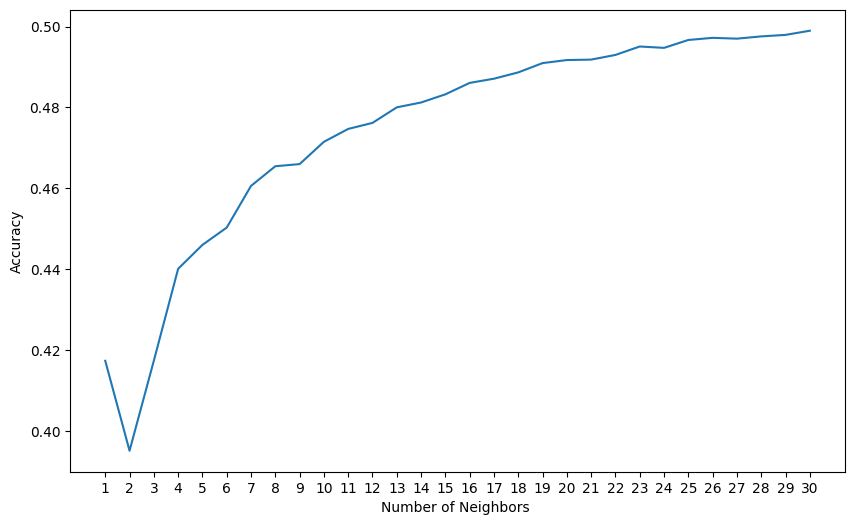

In [27]:
# calculating the accuracy of models with different values of k
mean_acc = np.zeros(30)
for i in range(1,31):
    #Train Model and Predict
    knn = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    y_predict= knn.predict(x_test)
    mean_acc[i-1] = metrics.accuracy_score(y_test, y_predict)

print(mean_acc)

loc = np.arange(1,31,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,31), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

# Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
grid_params = { 'n_neighbors' : [15,17,19,21,23,25,27,29],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [30]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [31]:
# fit the model on our train set
g_res = gs.fit(x_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [32]:
# get the hyperparameters with the best score
g_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 29, 'weights': 'uniform'}

In [33]:
# Define the model using the resulting best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 29, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=29)

In [34]:
# Make predictions on the test data
y_predict = knn.predict(x_test)

# Model Evaluation

In [35]:
#Evaluated model based on different metrics
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_predict))

Test set accuracy:  0.4975490471009209


In [36]:
# Generated a classification report

report = classification_report(y_test, y_predict, output_dict=True)
report = pd.DataFrame(report).transpose()

print("Classification Report:\n",report)

Classification Report:
               precision    recall  f1-score       support
0              0.294039  0.100330  0.149610  17602.000000
1              0.282272  0.037788  0.066653   4340.000000
2              0.492387  0.737379  0.590480  36269.000000
3              0.281250  0.032028  0.057508    281.000000
4              0.555485  0.511237  0.532443  30657.000000
accuracy       0.497549  0.497549  0.497549      0.497549
macro avg      0.381087  0.283752  0.279339  89149.000000
weighted avg   0.464028  0.497549  0.456293  89149.000000


In [37]:
# Generated a confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:\n",conf_matrix)


Confusion Matrix:
 [[ 1766    78 11362     6  4390]
 [  272   164  2842     0  1062]
 [ 2320   217 26744     8  6980]
 [   17     1   144     9   110]
 [ 1631   121 13223     9 15673]]


Text(0.5, 23.52222222222222, 'Predicted label')

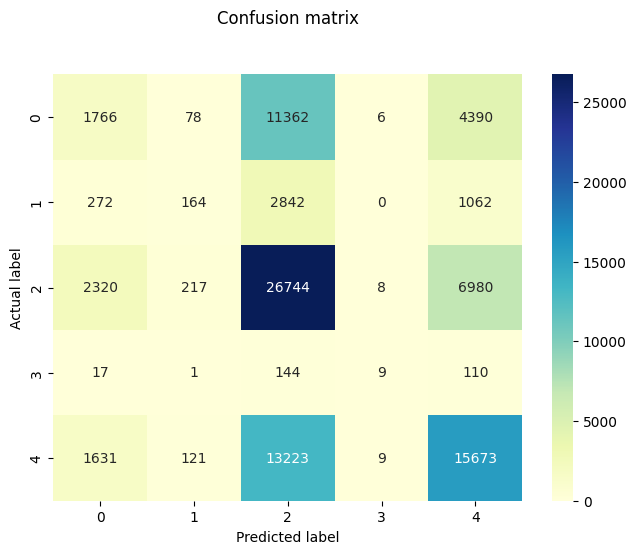

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns

sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [39]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, data, labels_encoded, cv =5)

In [40]:
#Model accuracy

print('Model accuracy: ',np.mean(scores))

Model accuracy:  0.4558580377571225


## Results:

- Confusion Matrix

Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. From the matrix, it seems like the second class has the highest number of correct predictions (26747), as it’s the highest number in the diagonal of the matrix. However, there also seems to be a significant number of misclassifications.
Overall, the result are better than the previous one, but still quite similar.


- Report (Accuracy, Precision, Recall, F1 score)

**Exchanges(Class 0)**: Precision is 0.294, recall is 0.099, and F1-score is 0.148. This means the model is not performing well on this class. It’s not accurately identifying class 0 instances (low precision), and it’s also missing a lot of actual class 0 instances (low recall).

**Gambling(Class 1)**: Similar to class 0, both precision (0.282) and recall (0.037) are low, indicating poor performance on this class.

**Historic(Class 2)**: The model performs relatively better on this class with a precision of 0.492 and recall of 0.737. However, there’s still room for improvement.

**Mining(Class 3)**: This class has the lowest recall (0.032), indicating that the model is missing almost all actual class 3 instances. Precision is also low (0.281).

**Service(Class 4)**: This class has the highest precision (0.555) and recall (0.511) among all classes, indicating the best performance on this class.

The overall accuracy of the model is 0.497, so compared to the previous score of 0.446 it is better, however we can still improve it, since there is still room for improvement.


## **CLUSTERING**


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(features)
#In order to define the features to use for the K-clustering, I define those that have a significant variability and those that can be independent of each other.
data.corr()

<ipython-input-41-424a1a096088>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Transaction_Count,Total_Amount,Average_Amount,Average_Partners_Per_Day
Transaction_Count,1.000000,0.073635,-0.001169,0.591477
Total_Amount,0.073635,1.000000,0.160857,0.053869
Average_Amount,-0.001169,0.160857,1.000000,-0.002733
Average_Partners_Per_Day,0.591477,0.053869,-0.002733,1.000000


In [42]:
data.describe()

,Transaction_Count,Total_Amount,Average_Amount,Average_Partners_Per_Day
count,2.820031e+06,2.820031e+06,2.820031e+06,2.820031e+06
mean,2.438187e+00,5.225207e+01,2.831648e+01,1.156549e+00
std,7.842004e+01,1.536289e+03,1.831819e+02,3.070772e+00
min,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e+00
25%,1.000000e+00,4.213233e-01,3.703449e-01,1.000000e+00
50%,1.000000e+00,2.759058e+00,2.247500e+00,1.000000e+00
75%,1.000000e+00,1.415190e+01,1.148368e+01,1.000000e+00
max,3.843400e+04,1.877023e+06,4.800060e+04,2.334000e+03


              x          y
0     29.546881  -0.216053
1     29.495034  -0.216233
2     28.257678  -0.207402
3     27.542658  -0.213490
4     26.962284  -0.215714
...         ...        ...
9995  -0.158960  -0.027736
9996  -0.158960   0.464145
9997  -0.158960  -0.212213
9998  -0.158960  11.976880
9999  -0.158960  -0.211870

[10000 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers: 
[[-0.06942214 -0.0866833 ]
 [-0.06068293 31.17442467]
 [23.00813455 -0.2121102 ]
 [ 5.68803848 -0.20036712]
 [-0.12382527  2.36867717]]


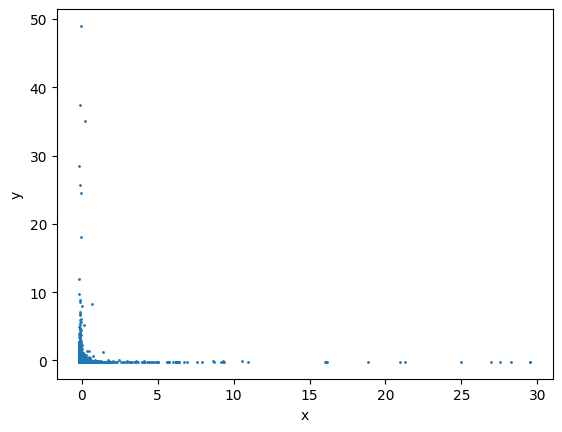

In [43]:
#In a scatter plot for K-means clustering, the axes are usually two of the features from your dataset that you want to compare or visualize.
#Since scatter plots are 2-dimensional, I have choosen two features for the axes.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#Segnment the data
subset_data = data.iloc[ : 10000, : ]

datax = subset_data.iloc[:,[1,3]]

#Standardize
scaler = StandardScaler()
datax = pd.DataFrame(scaler.fit_transform(datax))
datax.columns = ["x", "y"]

datax.plot.scatter(x = "x", y= "y", s = 1)
print(datax)

#Imposing the model to have 5 number of clusters
kmeans = KMeans(n_clusters = 5, random_state=1)

# Generate a model from the dataset
kmeans.fit(datax)
model= kmeans.fit(datax)

# Shows the result.
print("Cluster Centers: ")
print(kmeans.cluster_centers_)

<Axes: xlabel='x', ylabel='y'>

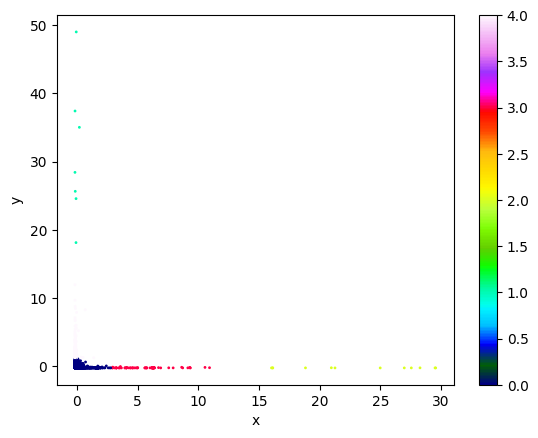

In [44]:
# Assign each element of the data set to a cluster number
labels = kmeans.predict(datax)

# Display results, using the cluster number as the color
datax.plot.scatter(x="x",y="y",c=labels,s=1,cmap='gist_ncar')


In [45]:
# Evaluate the quality of the prediction

score = silhouette_score(datax, labels)

print( "Quality of predictions:" + str(score))

Quality of predictions:0.8678316232593608


**This part is going to find out the "best" number of clusters, compute K-means for the value of K from 2 to 20, and plot the Silhouette value. The maximum value is the clustering with best quality**

Repeating same process, but this time without forcing the number of clusters, but evaluating in advance the optimal number of clusters according to the prediction of the model.

This time the model is run with Spark.

We have segmented data, because otherwise it was not possible to run the code without finishing the RAM.

In [46]:
#Segnment the data
subset_data = data.iloc[ : 10000, : ]

datax = subset_data.iloc[:,[1,3]]

In [49]:

from pyspark.ml.feature import VectorAssembler
features_spark = spark.createDataFrame(datax)
assembler = VectorAssembler(inputCols=('Transaction_Count','Average_Amount'),outputCol="features")
dataset = assembler.transform(features_spark)

In [50]:
#This function is going to evaluate the score of a k specific numbers of clusters
from pyspark.ml.clustering import KMeans
def evaluate( dataset, k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score

In [ ]:
# For each value from 2 to 20 compute the clusters and the score
df = pd.DataFrame(columns=['num','score'])
for i in range(2,20):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(dataset,i)}).to_frame().T], ignore_index=True)

# This plot a graphic with all the scores from 2 to 19
df.plot( x="num", y="score")

In [ ]:
#Let's print the clustering that leads to a better result
k = int(df.nlargest(1,"score")["num"].values[0])

kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(dataset)
predictions = model.transform(dataset)

predictionsPD = predictions.toPandas()
# Display results, using the cluster number as the color
predictionsPD.plot.scatter(x='x',y='y',c="prediction",s=1,cmap='gist_ncar')

In [ ]:
#Evaluate the quality of the prediction
evaluator = ClusteringEvaluator()
score = evaluator.evaluate(predictions)

print( "Quality of predictions (higher is better):" + str(score))